In [188]:
# import sys
# sys.path.append("/Assignments/4Assignment_inverse_problems")
import numpy as np
import matplotlib.pyplot as plt
import general_functions as gf
from scipy.optimize import curve_fit


In [189]:
#1: Naive parallelization #OPT=0g was used
#pragma omp parallel for 
#time_FFT_strong = [0.05069, 0.0499, 0.05041, 0.05242, 0.1368, 0.1272, 0.05459]
#time_wo_FFT_strong = [0.8465, 0.4213, 0.2133, 0.1734, 0.1646, 0.2626, 0.1774]
#time_FFT_weak = [0.07774, 0.1271, 0.3031, 0.5874, 1.171, 2.399, 5.002]
#time_wo_FFT_weak = [0.2121, 0.3789, 0.8675, 1.71, 3.514, 7.174, 14.35]

### #2: OMP_LOOP_HIGH_LEVEL=1 #OPT=03 was used

In [ ]:
time_v1 = np.array([[],
                    [],
                    [],
                    []])

In [190]:
# FFT time, strong scaling
time_FFT_strong_data1 = np.array([0.04398, 0.04435, 0.04136, 0.04313, 0.04533, 0.0459, 0.04368])
time_FFT_strong_data2 = np.array([0.04185, 0.04158, 0.04129, 0.04136, 0.04154, 0.04144, 0.04802])
time_FFT_strong_data3 = np.array([0.04109, 0.04374, 0.0414, 0.05874, 0.04244, 0.04098, 0.04373])
time_FFT_strong_data4 = np.array([0.05452, 0.04151, 0.04181, 0.04382, 0.04536, 0.1068, 0.0871])
time_FFT_strong_data5 = np.array([0.04223, 0.04597, 0.04131, 0.04229, 0.04632, 0.04112, 0.04462])
time_FFT_strong_data_all = np.vstack((time_FFT_strong_data1, time_FFT_strong_data2, time_FFT_strong_data3, time_FFT_strong_data4, time_FFT_strong_data5))

# Without FFT time, strong scaling
time_wo_FFT_strong_data1 = np.array([0.1181, 0.06835, 0.1029, 0.06956, 0.07212, 0.106, 0.1018])
time_wo_FFT_strong_data2 = np.array([0.08455, 0.1166, 0.119, 0.08071, 0.1019, 0.1126, 0.1006])
time_wo_FFT_strong_data3 = np.array([0.07243, 0.1255, 0.07429, 0.1175, 0.1187, 0.1002, 0.1159])
time_wo_FFT_strong_data4 = np.array([0.06879, 0.09403, 0.1274, 0.07235, 0.1235, 0.09018, 0.06822])
time_wo_FFT_strong_data5 = np.array([0.07287, 0.09818, 0.08193, 0.1188, 0.09166, 0.07257, 0.1351])
time_wo_FFT_strong_data_all = np.vstack((time_wo_FFT_strong_data1, time_wo_FFT_strong_data2, time_wo_FFT_strong_data3, time_wo_FFT_strong_data4, time_wo_FFT_strong_data5))

# Time with FFT, weak scaling 
time_FFT_weak_data1 = np.array([0.04632, 0.1313, 0.1825, 0.4299, 0.8225, 1.675,3.711])
time_FFT_weak_data2 = np.array([0.04192, 0.08911, 0.1844, 0.3949, 0.7972, 1.683,3.602])
time_FFT_weak_data3 = np.array([0.04586, 0.09101, 0.1828, 0.3864, 0.8308, 1.749,3.555])
time_FFT_weak_data4 = np.array([0.04598, 0.08885, 0.1885, 0.4287, 0.8443, 1.671,3.588])
time_FFT_weak_data5 = np.array([0.04133, 0.09345, 0.2078, 0.3937, 0.7923, 1.677,3.567])
time_FFT_weak_data_all = np.vstack((time_FFT_weak_data1, time_FFT_weak_data2, time_FFT_weak_data3, time_FFT_weak_data4, time_FFT_weak_data5))

# Time without FFT, weak scaling
time_wo_FFT_weak_data1 = np.array([0.1038, 0.2335, 0.5334, 1.133, 2.254, 4.375, 8.848])
time_wo_FFT_weak_data2 = np.array([0.1044, 0.2867, 0.5627, 1.103, 2.25, 4.352, 8.866])
time_wo_FFT_weak_data3 = np.array([0.107, 0.2446, 0.5339, 1.067, 2.135, 4.357, 8.88])
time_wo_FFT_weak_data4 = np.array([0.1267, 0.2778, 0.5231, 1.059, 2.226, 4.377, 8.903])
time_wo_FFT_weak_data5 = np.array([0.1089, 0.2343, 0.4783, 1.071, 2.205, 4.459, 8.932])
time_wo_FFT_weak_data_all = np.vstack((time_wo_FFT_weak_data1, time_wo_FFT_weak_data2, time_wo_FFT_weak_data3, time_wo_FFT_weak_data4, time_wo_FFT_weak_data5))

# Total time
time_total_strong_data = time_FFT_strong_data_all + time_wo_FFT_strong_data_all
time_total_weak_data = time_FFT_weak_data_all + time_wo_FFT_weak_data_all

#Threads used
n_threads_strong = np.array([1, 2, 4, 8, 16, 32, 64])
n_threads_weak = np.array([1, 2, 4, 8, 16, 32, 64])


### #3 Final version
NTHREADS=4

In [191]:
time_FFT_strong_final_data_all = np.array([[0.3601, 0.2795, 0.2463, 0.227, 0.2191, 0.2207, 0.2302],
                                           [0.3593, 0.2797, 0.2471, 0.2356, 0.2187, 0.2186, 0.221],
                                           [0.3619, 0.2809, 0.2489, 0.2276, 0.2173, 0.2181, 0.2275],
                                           [0.36, 0.2804, 0.2487, 0.227, 0.2186, 0.2192, 0.2235]])

time_wo_FFT_strong_final_data_all = np.array([[3.008, 1.514, 0.9335, 0.4719, 0.2437, 0.1195, 0.07109],
                                              [3.008, 1.515, 0.9344, 0.4738, 0.242, 0.1196, 0.07063],
                                              [3.011, 1.515, 0.9369, 0.4719, 0.2435, 0.1202, 0.07073],
                                              [3.01, 1.512, 0.9337, 0.4736, 0.2427, 0.1183, 0.06986]])

time_FFT_weak_final_data_all = np.array([[0.08287, 0.1348, 0.2467, 0.4788, 0.9157, 1.887, 3.882],
                                   [0.08158, 0.133, 0.2466, 0.4635, 0.9269, 1.846, 3.885],
                                   [0.08189, 0.1336, 0.2446, 0.484, 0.9247, 1.838, 3.879],
                                   [0.0814, 0.134, 0.2478, 0.4729, 0.94, 1.857, 3.859] ,])

time_wo_FFT_weak_final_data_all = np.array([[0.7547, 0.7566, 0.9362, 0.9429, 0.9636, 0.9218, 1.003],
                                            [0.7537, 0.7553, 0.9248, 0.9419, 0.9594, 0.9202, 0.9803], 
                                            [0.7539, 0.7573, 0.9403, 0.941, 0.9665, 0.9215, 0.9813],
                                            [0.7534, 0.7577, 0.9347, 0.9518, 0.9642, 0.9216, 0.9836],])

time_total_strong_final_data = time_FFT_strong_final_data_all + time_wo_FFT_strong_final_data_all
time_total_weak_final_data = time_FFT_weak_final_data_all + time_wo_FFT_weak_final_data_all

Get mean, std and relative speedup of data

In [215]:
def error_prop_speedup(t_N_vals, t1, std_t_N_vals, std_t1):
    term1 = std_t1 / t_N_vals
    term2  = -0.5 * t1 / (t_N_vals ** 2) * std_t_N_vals
    std_total = np.sqrt(term1 ** 2 + term2 ** 2)
    return std_total


def abs_and_rel_speedup(data_all, weak_scaling=False):
    # Absolute
    abs_speed_mean = np.mean(data_all, axis=0)
    abs_speed_std = np.std(data_all, axis=0) / np.sqrt((len(abs_speed_mean)-1))  # Bessel's correction
    
    # Relative speedup
    # Divide all data points by the nthreads=1 points.
    t1_vals = data_all[:, 0][:, None]
    std_t1_vals = abs_speed_std[0]
    
    rel_speed_data = t1_vals / data_all  # np.divide(data_all.T, data_all[:, 0]).T
    rel_speed_mean = np.mean(rel_speed_data, axis=0)
    rel_speed_std_all = error_prop_speedup(data_all, t1_vals, abs_speed_std, std_t1_vals)
    rel_speed_std = np.mean(rel_speed_std_all, axis=0)
    if weak_scaling:
         rel_speed_mean *= n_threads_strong
         rel_speed_std *= n_threads_strong
    
    return abs_speed_mean, abs_speed_std, rel_speed_mean, rel_speed_std


# High level version of the code
time_FFT_strong, std_time_FFT_strong, rel_speed_time_FFT_strong, std_rel_speed_time_FFT_strong = abs_and_rel_speedup(time_FFT_strong_data_all)
time_wo_FFT_strong, std_time_wo_FFT_strong, rel_speed_time_wo_FFT_strong, std_rel_speed_time_wo_FFT_strong = abs_and_rel_speedup(time_wo_FFT_strong_data_all)
time_FFT_weak, std_time_FFT_weak, rel_speed_time_FFT_weak, std_rel_speed_time_FFT_weak = abs_and_rel_speedup(time_FFT_weak_data_all)
time_wo_FFT_weak, std_time_wo_FFT_weak, rel_speed_time_wo_FFT_weak, std_rel_speed_time_wo_FFT_weak = abs_and_rel_speedup(time_wo_FFT_weak_data_all, weak_scaling=True)

time_total_strong, std_time_total_strong, rel_speed_time_total_strong, std_rel_speed_time_total_strong = abs_and_rel_speedup(time_total_strong_data)
time_total_weak, std_time_total_weak, rel_speed_time_total_weak, std_rel_speed_time_total_weak = abs_and_rel_speedup(time_total_weak_data, weak_scaling=True)


# Final version of the code
time_FFT_strong_final, std_time_FFT_strong_final, rel_speed_time_FFT_strong_final, std_rel_speed_time_FFT_strong_final = abs_and_rel_speedup(time_FFT_strong_final_data_all)
time_wo_FFT_strong_final, std_time_wo_FFT_strong_final, rel_speed_time_wo_FFT_strong_final, std_rel_speed_time_wo_FFT_strong_final = abs_and_rel_speedup(time_wo_FFT_strong_final_data_all)
time_FFT_weak_final, std_time_FFT_weak_final, rel_speed_time_FFT_weak_final, std_rel_speed_time_FFT_weak_final = abs_and_rel_speedup(time_FFT_weak_final_data_all, weak_scaling=True)
time_wo_FFT_weak_final, std_time_wo_FFT_weak_final, rel_speed_time_wo_FFT_weak_final, std_rel_speed_time_wo_FFT_weak_final = abs_and_rel_speedup(time_wo_FFT_weak_final_data_all, weak_scaling=True)

time_total_strong_final, std_time_total_strong_final, rel_speed_time_total_strong_final, std_rel_speed_time_total_strong_final = abs_and_rel_speedup(time_total_strong_final_data)
time_total_weak_final, std_time_total_weak_final, rel_speed_time_total_weak_final, std_rel_speed_time_total_weak_final = abs_and_rel_speedup(time_total_weak_final_data, weak_scaling=True)

# Plot

#### Fitting

In [216]:
def amdahl_law_theoretical(N_processor, parallel_fraction):
    """Amdahl's law given the number of processors and the fraction of the program that is parallel."""
    S_latency = 1 / ((1 - parallel_fraction) + parallel_fraction / N_processor)
    return S_latency


def gustafs_law_theoretical(N_processor, parallel_fraction):
    speedup = 1 + (N_processor - 1) * parallel_fraction
    return speedup


def fit_scaling(f_fit, time, std_time, p0):
    par, cov = curve_fit(f_fit, n_threads_strong, time, sigma=std_time, p0=p0)
    err = np.sqrt(np.diag(cov))
    x_fit = np.linspace(n_threads_strong.min(), n_threads_strong.max(), 300)
    y_fit = f_fit(x_fit, *par)
    return par, err, x_fit, y_fit

In [217]:
# Fit values
par_total_strong, err_total_strong, x_fit_total_strong, y_fit_total_strong = fit_scaling(amdahl_law_theoretical, rel_speed_time_total_strong_final, std_rel_speed_time_total_strong_final, p0=(0.9, ))
par_total_weak, err_total_weak, x_fit_total_weak, y_fit_total_weak = fit_scaling(gustafs_law_theoretical, rel_speed_time_wo_FFT_weak_final, std_rel_speed_time_wo_FFT_weak_final, p0=(1, ))

### Plot the strong and week scaling together with fits

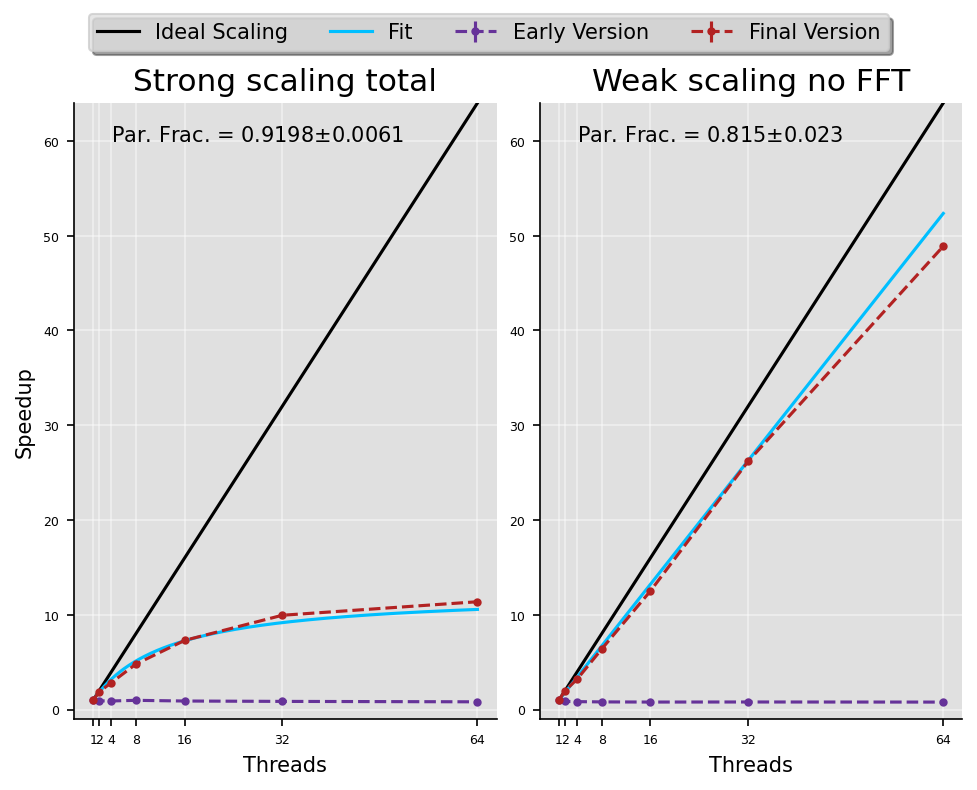

In [218]:
fig, (ax, ax_weak) = plt.subplots(ncols=2)
ylim = (-1, n_threads_strong.max())

# Strong scaling
ax.errorbar(n_threads_strong, rel_speed_time_total_strong, yerr=std_rel_speed_time_total_strong, fmt=".--", label="Early Version")
ax.errorbar(n_threads_strong, rel_speed_time_total_strong_final, yerr=std_rel_speed_time_total_strong_final, fmt=".--", label="Final Version")
ax.plot(n_threads_strong, n_threads_strong, ls="-", label="Ideal Scaling")
ax.plot(x_fit_total_strong, y_fit_total_strong, ls="-", c="deepskyblue", label="Fit")
ax.set(ylabel="Speedup", xlabel="Threads", title="Strong scaling total", ylim=ylim)
ax.set_xticks(ticks=n_threads_strong, labels=n_threads_strong, fontsize=6)
ax.set_yticks(ticks=np.arange(0, 70, 10), labels=np.arange(0, 70, 10), fontsize=6)
ax.grid()

# Weak scaling 
ax_weak.errorbar(n_threads_strong, rel_speed_time_wo_FFT_weak, yerr=std_rel_speed_time_wo_FFT_weak, fmt=".--", label="Early Version")
ax_weak.errorbar(n_threads_strong, rel_speed_time_wo_FFT_weak_final, yerr=std_rel_speed_time_wo_FFT_weak_final, fmt=".--", label="Final Version")
ax_weak.plot(n_threads_strong, n_threads_strong, ls="-", label="Ideal Scaling")
ax_weak.plot(x_fit_total_weak, y_fit_total_weak, ls="-", c="deepskyblue", label="Fit")
ax_weak.set(xlabel="Threads", title="Weak scaling no FFT", ylim=ylim)
ax_weak.set_xticks(ticks=n_threads_strong, labels=n_threads_strong, fontsize=6)
ax_weak.set_yticks(ticks=np.arange(0, 70, 10), labels=np.arange(0, 70, 10), fontsize=6)
ax_weak.grid()

# Text results
s_strong = f"Par. Frac. = {par_total_strong[0]:.4f}" + r"$\pm$" + f"{err_total_strong[0]:.4f}"
ax.text(4, 60, s_strong)
s_weak = f"Par. Frac. = {par_total_weak[0]:.3f}" + r"$\pm$" + f"{err_total_weak[0]:.3f}"
ax_weak.text(4, 60, s_weak)

# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)

fig.savefig("task2_scaling.png")
plt.show()

In [214]:
time_FFT_strong = [time_FFT_strong_data1[i] + time_FFT_strong_data2[i] + time_FFT_strong_data3[i] + time_FFT_strong_data4[i] + time_FFT_strong_data5[i] for i in range(len(n_threads_strong))]
time_wo_FFT_strong = [time_wo_FFT_strong_data1[i] + time_wo_FFT_strong_data2[i] + time_wo_FFT_strong_data3[i] + time_wo_FFT_strong_data4[i] + time_wo_FFT_strong_data5[i] for i in range(len(n_threads_strong))]
time_FFT_weak = [time_FFT_weak_data1[i] + time_FFT_weak_data2[i] + time_FFT_weak_data3[i] + time_FFT_weak_data4[i] + time_FFT_weak_data5[i] for i in range(len(n_threads_weak))]
time_wo_FFT_weak = [time_wo_FFT_weak_data1[i] + time_wo_FFT_weak_data2[i] + time_wo_FFT_weak_data3[i] + time_wo_FFT_weak_data4[i] + time_wo_FFT_weak_data5[i] for i in range(len(n_threads_weak))]

time_FFT_strong_std = np.std([time_FFT_strong_data1, time_FFT_strong_data2, time_FFT_strong_data3, time_FFT_strong_data4, time_FFT_strong_data5], axis=0)
time_wo_FFT_strong_std = np.std([time_wo_FFT_strong_data1, time_wo_FFT_strong_data2, time_wo_FFT_strong_data3, time_wo_FFT_strong_data4, time_wo_FFT_strong_data5], axis=0)
time_FFT_weak_std = np.std([time_FFT_weak_data1, time_FFT_weak_data2, time_FFT_weak_data3, time_FFT_weak_data4, time_FFT_weak_data5], axis=0)
time_wo_FFT_weak_std = np.std([time_wo_FFT_weak_data1, time_wo_FFT_weak_data2, time_wo_FFT_weak_data3, time_wo_FFT_weak_data4, time_wo_FFT_weak_data5], axis=0)


time_total_strong = [time_FFT_strong[i] + time_wo_FFT_strong[i] for i in range(len(time_FFT_strong))]
time_total_weak = [time_FFT_weak[i] + time_wo_FFT_weak[i] for i in range(len(time_FFT_weak))]

speedup_FFT_strong = [t/time_FFT_strong[0] for t in time_FFT_strong]
speedup_wo_FFT_strong = [t/time_wo_FFT_strong[0] for t in time_wo_FFT_strong]
speedup_total_strong = [t/time_total_strong[0] for t in time_total_strong]

speedup_FFT_weak = [t/time_FFT_weak[0] for t in time_FFT_weak]
speedup_wo_FFT_weak = [t/time_wo_FFT_weak[0] for t in time_wo_FFT_weak]
speedup_total_weak = [t/time_total_weak[0] for t in time_total_weak]

[0.22366999999999998, 0.21715, 0.20717000000000002, 0.22934000000000002, 0.22099, 0.27624, 0.26715]


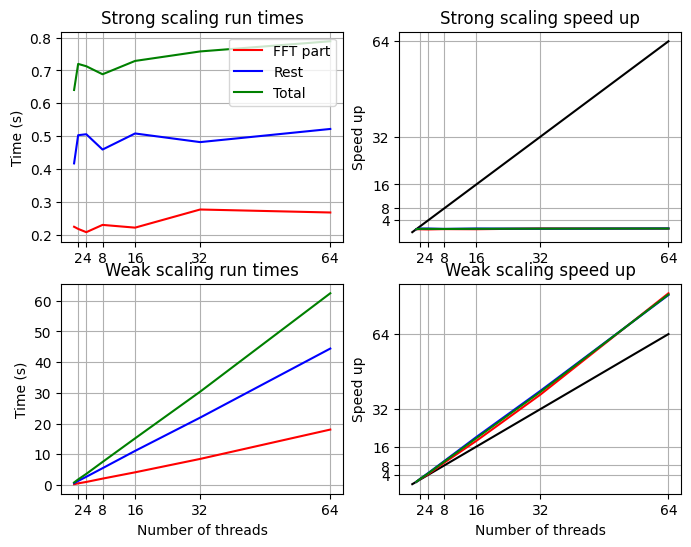

In [4]:
#plot the results

fig, axs = plt.subplots(2,2,figsize=(8, 6))
print(time_FFT_strong)
axs[0,0].plot(n_threads_strong, time_FFT_strong, label='FFT part',color='r')
axs[0,0].plot(n_threads_strong, time_wo_FFT_strong, label='Rest',color='b')
axs[0,0].plot(n_threads_strong, time_total_strong, label='Total',color='g')

axs[1,0].plot(n_threads_weak, time_FFT_weak, label='FFT part', color='r')
axs[1,0].plot(n_threads_weak, time_wo_FFT_weak, label='Rest', color='b')
axs[1,0].plot(n_threads_weak, time_total_weak, label='Total', color='g')

axs[0,0].set_xticks([2, 4, 8, 16, 32, 64])
axs[1,0].set_xticks([2, 4, 8, 16, 32, 64])
axs[0,1].set_xticks([2, 4, 8, 16, 32, 64])
axs[1,1].set_xticks([2, 4, 8, 16, 32, 64])
axs[0,1].set_yticks([4, 8, 16, 32, 64])
axs[1,1].set_yticks([4, 8, 16, 32, 64])
x_values = [0, 64]
y_values = [0, 64]

# Plot the line
axs[0,1].plot(x_values, y_values,color='black')
axs[1,1].plot(x_values, y_values,color='black')

axs[0,1].plot(n_threads_strong, speedup_FFT_strong, label='FFT part',color='r')
axs[0,1].plot(n_threads_strong, speedup_wo_FFT_strong, label='Rest',color='b')
axs[0,1].plot(n_threads_strong, speedup_total_strong, label='Combined',color='g')

axs[1,1].plot(n_threads_weak, speedup_FFT_weak, label='FFT part',color='r')
axs[1,1].plot(n_threads_weak, speedup_wo_FFT_weak, label='Rest',color='b')
axs[1,1].plot(n_threads_weak, speedup_total_weak, label='Combined',color='g')

axs[1,0].set_xlabel('Number of threads')
axs[1,1].set_xlabel('Number of threads')
axs[0,0].set_ylabel('Time (s)')
axs[1,0].set_ylabel('Time (s)')
axs[0,1].set_ylabel('Speed up')
axs[1,1].set_ylabel('Speed up')

#set grid
axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()
axs[0,0].set_title('Strong scaling run times')
axs[1,0].set_title('Weak scaling run times')
axs[0,1].set_title('Strong scaling speed up')
axs[1,1].set_title('Weak scaling speed up')
axs[0,0].legend()

plt.show()